In [117]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
import acd
from tqdm import tqdm
import pickle as pkl
import torchvision
import models
import time
sys.path.append('..')
sys.path.append('../..')
plt.style.use('dark_background')
from visualize import *
import visualize as viz
from transforms_np import bandpass_filter
from numpy.fft import *
from data import *
from style import *
data_path = '/scratch/users/vision/data/cosmo'
torch.manual_seed(42)
np.random.seed(42)
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  oj(data_path, 'z1_256'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
print(len(mnu_dataset))
for r in mnu_dataset.params[:, 1:-1]:
    print(r[0], '&', r[1], '&', r[2], '\\\\')

**show an image**

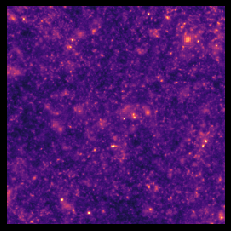

In [118]:
im = mnu_dataset[0]['image'].astype(np.float32)
#     plt.title(r"$m_\nu$=%0.2f; $\Omega_m$=%0.2f; $10^9A_s$=%0.2f"%(sample['params'][0], sample['params'][1], sample['params'][2] ) )
cshow(im)

**what are the units?**

In [3]:
sample_spacing = 0.8 # arcmins
freq_arr = fftshift(fftfreq(n=im.shape[0], d=sample_spacing)) # 1 / arcmin
print(freq_arr[0], freq_arr[-1])

-0.625 0.6201171875


**look at some examples**

In [ ]:
R, C = 1, 6
plt.figure(figsize=(C, R))
for i in range(R * C):
    sample = mnu_dataset[i]
    plt.subplot(R, C, i + 1)
    plt.axis('off')
    plt.imshow(np.squeeze(sample['image']), cmap='magma',vmax=0.15,vmin=-0.05 )

plt.tight_layout()
plt.show()

In [ ]:
viz.visualize(im, bandpass_filter)

**look at many frequencies**

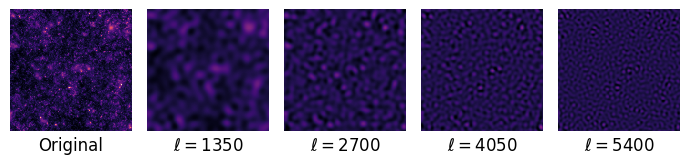

In [116]:
R, C = 1, 5
plt.figure(figsize=(C * 1.4, R * 2))
for i in range(R * C):
    band_center = i * 0.5 / 10
    b = band_center * np.max(np.abs(freq_arr)) * 2 * np.pi / np.radians(0.8/60)
    plt.subplot(R, C, i + 1)
    vmin = im.min()
    vmax = im.max()
    if i == 0:
        plt.imshow(im, cmap='magma') #, vmax=0.15, vmin=-0.05)
        plt.title('Original', y=-0.22)
    else:
        plt.title(f'$\ell=${b:0.0f}', y=-0.22)
#         axes[-1].set_title(f'{b:0.0f}', y=-0.4)
#         plt.title(f'{band_center:0.2f}')        
        plt.imshow(bandpass_filter(im, band_center=band_center), 
                   cmap='magma', vmin=vmin, vmax=vmax) #, vmax=0.15, vmin=-0.05)
    plt.axis('off')
plt.tight_layout()
plt.savefig('fig_filtered_ims.pdf')

# look at outcome of running cd

In [94]:
band_centers = np.linspace(0.1, 0.90, 100)
bs = band_centers * np.max(np.abs(freq_arr)) * 2 * np.pi / np.radians(0.8/60)
scores_list = pkl.load(open('results/scores_list_880.pkl', 'rb'))['scores_list'] # (num_curves, num_bands, num_outcomes)
preds_list = pkl.load(open('results/scores_list_880.pkl', 'rb'))['preds_list'] # (num_curves, num_outcomes)
params_list = [mnu_dataset[i]['params'] for i in range(10)]

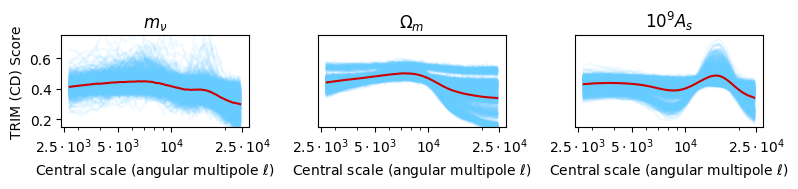

In [119]:
R, C = 1, 3
tits = [f"$m_\\nu$", "$\Omega_m$", "$10^9A_s$"]
plt.style.use('default')
plt.figure(figsize=(C * 2.7, R * 2))
for class_num in range(3):
    ax = plt.subplot(R, C, class_num  + 1)
    viz.plot_all(bs, scores_list, preds_list, params_list, class_num=class_num, tit=tits[class_num]) # plot all
    plt.ylim(0.15, 0.75)
    if class_num > 0:
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
    else:
        plt.ylabel('TRIM (CD) Score')
        
    plt.xscale('log')
    plt.xticks([2.5e3, 5e3, 1e4, 2.5e4], labels=['$2.5 \cdot 10^3$', '$5 \cdot 10^3$', '$10^4$', '$2.5 \cdot 10^4$'])
plt.tight_layout()
plt.savefig(f'fig_freq_curves.pdf')
plt.show()

**plot bands one by one**

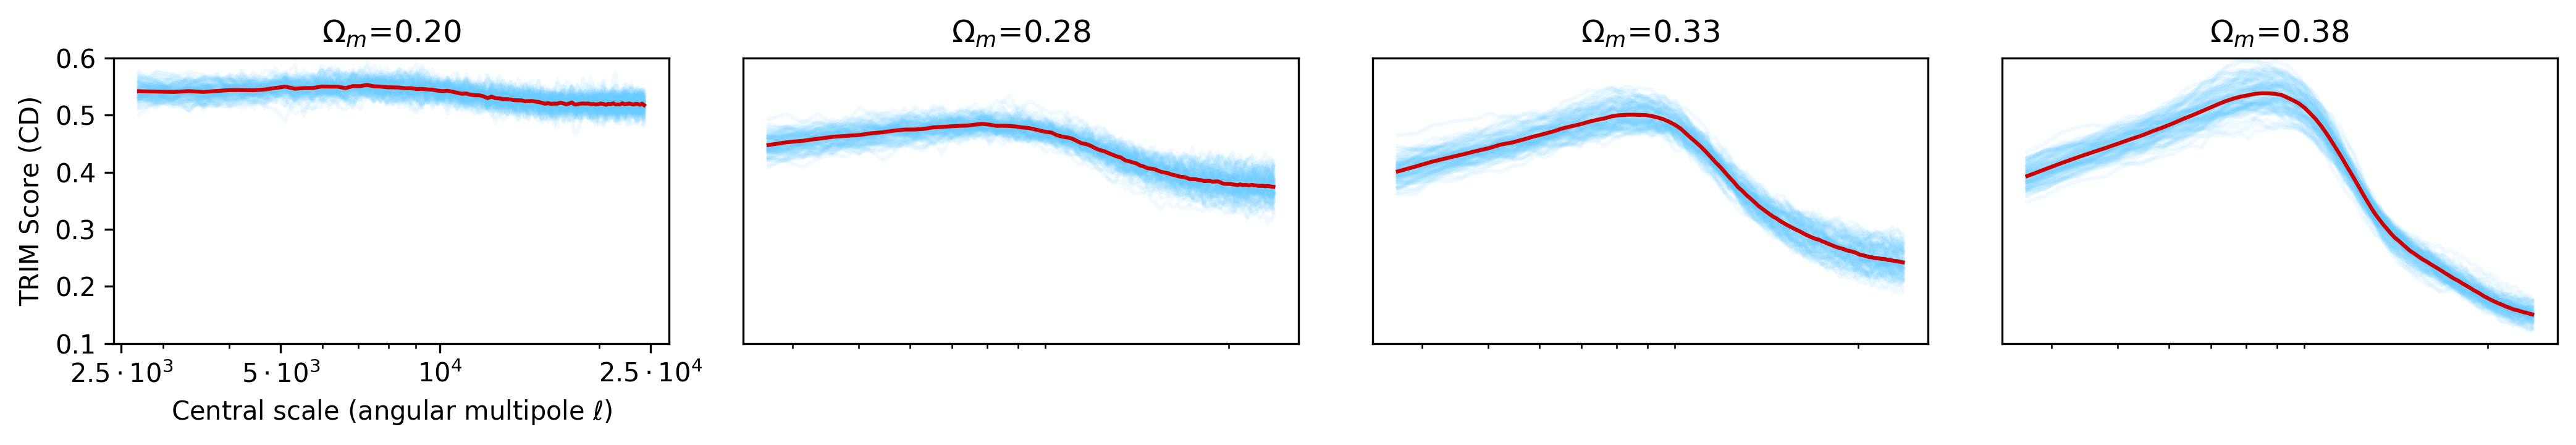

In [120]:
R, C = 1, 4
param_nums = np.array([4, 8, 5, 1], dtype=np.int)
for class_num in [1]:
    plt.figure(figsize=(14, 2.5), dpi=300) #figsize=(20, 12))
    i = 0
    for r in range(R):
        for c in range(C):
            plt.subplot(R, C, i + 1)
            plot_all(bs, scores_list, preds_list, params_list, class_num=class_num, param_num=param_nums[i])
            i += 1

#             plt.axis('off')
#             plt.title('')
            params = params_list[param_nums[i - 1]]
            plt.title(f"$\Omega_m$={params[1]:0.2f}")
            plt.ylim((0.1, 0.6))
            plt.xscale('log')
            plt.xticks([2.5e3, 5e3, 1e4, 2.5e4], labels=['$2.5 \cdot 10^3$', '$5 \cdot 10^3$', '$10^4$', '$2.5 \cdot 10^4$'])
            if c > 0:
                plt.xticks([])
                plt.yticks([])            
                plt.ylabel('')
                plt.xlabel('')
            if c == 0:
                plt.ylabel('TRIM Score (CD)')
            if i == R * C:
                break         
    plt.tight_layout()
#     plt.subplot(R, C, R * C)
#     plot_all(scores_list, preds_list, params_list, class_num=class_num) # plot all
#     plt.tight_layout()
plt.savefig(f'fig_bands_omegaM.pdf')
plt.show()

**make paper fig**

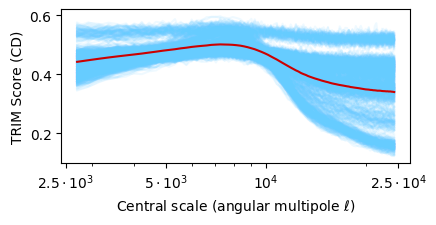

In [121]:
plt.style.use('default')
plt.figure(figsize=(4.5, 2))
class_num = 1 # omegam
# plt.figure(figsize=(C * 2, R * 2))
# fig = plt.figure(constrained_layout=True, figsize=(C * 2-5, R * 2))
# gs = fig.add_gridspec(1, C)
axes = []

viz.plot_all(bs, scores_list, preds_list, params_list, class_num=class_num, tit='') #, ax=axes[-1])
plt.xscale('log')
plt.ylabel('TRIM Score (CD)')
plt.xticks([2.5e3, 5e3, 1e4, 2.5e4], labels=['$2.5 \cdot 10^3$', '$5 \cdot 10^3$', '$10^4$', '$2.5 \cdot 10^4$'])
plt.savefig('fig_omegaM_full.pdf', bbox_inches = 'tight',
    pad_inches = 0)